In [61]:
import os
import re
import json
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive

warnings.filterwarnings("ignore")

In [62]:
# Пути к данным
house_path = "/content/data/house_dataset.csv"
antagonists_path = "/content/data/antagonists_dataset.csv"

# Загрузка данных
house_df = pd.read_csv(house_path)
antagonists_df = pd.read_csv(antagonists_path)

# Вывод первых строк для проверки
print("Первые строки датасета Доктора Хауса:")
print(house_df.head())

print("Первые строки датасета антагонистов:")
print(antagonists_df.head())

Первые строки датасета Доктора Хауса:
    name  season                                      previous_line  \
0  house       1  Fair enough. I dont like healthy Patients. The...   
1  house       1  Shouldnt we be speaking to the Patient before ...   
2  house       1                                           No, but!   
3  house       1      Isnt treating Patients why we became doctors?   
4  house       1                                           Mad cow?   

  previous_speaker                                       context_long  \
0           wilson  See that? They all assume Im a Patient because...   
1          foreman  And shes not responding to radiation treatment...   
2          foreman  Come on! Why leave all the fun for the coroner...   
3          foreman  Shouldnt we be speaking to the Patient before ...   
4            chase  First year of medical school if you hear hoof ...   

   is_greeting  is_question  is_negation  is_exclamation  is_sarcasm  \
0        False        Fa

In [63]:
import re
import pandas as pd

def clean_text(text):
    """Очистка текста от проблемных символов, лишних пробелов и мусора."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    text = text.replace("�", "")  # Удаление неизвестных символов
    text = re.sub(r"\s+", " ", text).strip()  # Убираем лишние пробелы
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Удаляем любые не-ASCII символы (если есть)

    return text

def additional_cleaning(text):
    """Дополнительная очистка с учетом чисел, процентов, дробей и случайных заглавных букв."""
    if not isinstance(text, str):
        return text

    # Разрешенные символы: буквы, цифры, пробелы, знаки пунктуации, проценты, доллар, дроби
    text = re.sub(r"[^\w\s.,!?'$/%-]", "", text)

    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text).strip()

    # Исправление случайных заглавных букв в середине слова
    words = text.split()
    cleaned_words = []
    for word in words:
        if re.search(r"[A-Z][a-z]+[A-Z]", word):  # Проверка случайной заглавной буквы в середине слова
            word = word.lower()
        cleaned_words.append(word)

    return " ".join(cleaned_words)

def apply_text_cleaning(df, text_columns):
    """Очистка всех указанных текстовых колонок и сбор статистики."""

    stats = {}

    for col in text_columns:
        initial_non_empty = df[col].notna().sum()  # Количество непустых значений до очистки
        total_chars_before = df[col].dropna().apply(len).sum()  # Общее количество символов до очистки

        # Очистка
        df[col] = df[col].astype(str).apply(clean_text).apply(additional_cleaning)

        total_chars_after = df[col].dropna().apply(len).sum()  # Общее количество символов после очистки
        cleaned_chars = total_chars_before - total_chars_after  # Удалено символов
        final_non_empty = df[col].notna().sum()  # Количество непустых значений после очистки

        stats[col] = {
            "исходные строки": initial_non_empty,
            "очищенные строки": final_non_empty,
            "удалено пустых строк": initial_non_empty - final_non_empty,
            "общая длина до очистки": total_chars_before,
            "общая длина после очистки": total_chars_after,
            "удалено символов": cleaned_chars,
        }

    return df, stats

# Определение всех текстовых колонок, которые нужно очистить
text_columns_house = ["line", "previous_line", "context_1", "context_2", "context_3", "context_4", "context_5", "context_long"]
text_columns_antagonists = ["line"]

# Очистка текстовых колонок в датасете Доктора Хауса и Антагонистов
house_df, house_stats = apply_text_cleaning(house_df, text_columns_house)
antagonists_df, antagonists_stats = apply_text_cleaning(antagonists_df, text_columns_antagonists)

# Вывод статистики для Доктора Хауса
print("\nСТАТИСТИКА ОЧИСТКИ: ДОКТОР ХАУС")
for col, stats in house_stats.items():
    print(f"\nКолонка: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# Вывод статистики для Антагонистов
print("\nСТАТИСТИКА ОЧИСТКИ: АНТАГОНИСТЫ")
for col, stats in antagonists_stats.items():
    print(f"\nКолонка: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# Примеры изменений до и после очистки
print("\nПРИМЕРЫ ДО И ПОСЛЕ ОЧИСТКИ:")

for col in text_columns_house:
    sample_before = house_df[col].dropna().sample(1, random_state=42).values[0]
    sample_after = additional_cleaning(clean_text(sample_before))
    print(f"\nКолонка: {col}")
    print(f"До: {sample_before}")
    print(f"После: {sample_after}")



СТАТИСТИКА ОЧИСТКИ: ДОКТОР ХАУС

Колонка: line
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 625471
- общая длина после очистки: 624772
- удалено символов: 699

Колонка: previous_line
- исходные строки: 8556
- очищенные строки: 8557
- удалено пустых строк: -1
- общая длина до очистки: 471335
- общая длина после очистки: 470778
- удалено символов: 557

Колонка: context_1
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 1260155
- общая длина после очистки: 1258465
- удалено символов: 1690

Колонка: context_2
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 1742933
- общая длина после очистки: 1740463
- удалено символов: 2470

Колонка: context_3
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 2237341
- общая длина после очистки: 2234105
- удалено символов: 3236

Колонка: context_

In [65]:
# Параметры фильтрации
MAX_REPLIES_PER_CHARACTER = 5000
MIN_HOUSE_WORD_COUNT = 3  # Минимальное количество слов в реплике для Доктора Хауса
MIN_ANTAGONISTS_WORD_COUNT = 5  # Минимальное количество слов в реплике для Антагонистов
MIN_LINE_LENGTH = 10  # Минимальная длина реплики в символах

def count_words(text):
    """Подсчет количества слов в тексте."""
    return len(text.split()) if isinstance(text, str) else 0

def filter_dataframe(df, min_word_count, text_column="line", group_by_character=True):
    """Удаление пустых строк, коротких реплик, вопросов, дубликатов и подозрительных символов."""

    initial_count = len(df)

    # Удаление пустых значений
    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    after_na_removal = len(df)

    # Удаление слишком коротких реплик
    df = df[df[text_column].str.len() >= MIN_LINE_LENGTH].reset_index(drop=True)
    after_length_filter = len(df)

    # Удаление вопросов
    df = df[~df[text_column].str.match(r"^[^.!?]+\?$", na=False)].reset_index(drop=True)
    df = df[~df[text_column].str.endswith("?")].reset_index(drop=True)
    after_question_filter = len(df)

    # Удаление дубликатов
    df = df.drop_duplicates(subset=[text_column]).reset_index(drop=True)
    after_duplicates_removal = len(df)

    # Фильтрация реплик по количеству слов
    df["word_count"] = df[text_column].apply(count_words)
    df = df[df["word_count"] >= min_word_count].drop(columns=["word_count"]).reset_index(drop=True)
    after_word_count_filter = len(df)

    # Ограничение количества реплик на персонажа
    if group_by_character and "character" in df.columns:
        df = df.groupby("character").apply(
            lambda x: x.sample(n=min(len(x), MAX_REPLIES_PER_CHARACTER), random_state=42)
        ).reset_index(drop=True)

    final_count = len(df)

    # Вывод статистики по удалению строк
    print(f"Удалено пустых строк: {initial_count - after_na_removal}")
    print(f"Удалено коротких строк (<{MIN_LINE_LENGTH} символов): {after_na_removal - after_length_filter}")
    print(f"Удалено вопросов: {after_length_filter - after_question_filter}")
    print(f"Удалено дубликатов: {after_question_filter - after_duplicates_removal}")
    print(f"Удалено строк с малым количеством слов (<{min_word_count}): {after_duplicates_removal - after_word_count_filter}")
    print(f"Итоговое количество строк: {final_count}\n")

    return df

# Запуск фильтрации данных
house_df = filter_dataframe(house_df, min_word_count=MIN_HOUSE_WORD_COUNT, group_by_character=False)
antagonists_df = filter_dataframe(antagonists_df, min_word_count=MIN_ANTAGONISTS_WORD_COUNT)

# Вывод статистики
print(f"\nКоличество реплик после очистки: {len(house_df)} (Доктор Хаус), {len(antagonists_df)} (Антагонисты).")

Удалено пустых строк: 0
Удалено коротких строк (<10 символов): 430
Удалено вопросов: 446
Удалено дубликатов: 47
Удалено строк с малым количеством слов (<3): 217
Итоговое количество строк: 7417

Удалено пустых строк: 0
Удалено коротких строк (<10 символов): 1555
Удалено вопросов: 9677
Удалено дубликатов: 1168
Удалено строк с малым количеством слов (<5): 11842
Итоговое количество строк: 57840


Количество реплик после очистки: 7417 (Доктор Хаус), 57840 (Антагонисты).


In [67]:
MAX_LINE_LENGTH = 30  # Максимальная длина после разбиения на чанки

def split_into_chunks(text, max_length=MAX_LINE_LENGTH):
    """Разбивает текст на чанки по количеству слов."""
    if not isinstance(text, str):  # Проверка на корректный тип
        return []

    words = text.split()
    chunks = [" ".join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

    return chunks

def apply_chunking(df, text_column="line"):
    """Разбивает длинные реплики на чанки и выводит статистику по изменениям."""

    initial_count = len(df)

    # Разбиение на чанки и обработка NaN
    df[text_column] = df[text_column].fillna("").apply(lambda x: split_into_chunks(x))

    # Подсчет общего количества чанков до обработки
    total_chunks_before = df[text_column].apply(lambda x: 1 if isinstance(x, str) else len(x)).sum()

    # Разбиение строк на отдельные чанки
    df = df.explode(text_column).reset_index(drop=True)

    # Подсчет статистики после обработки
    final_count = len(df)
    total_chunks_after = df[text_column].apply(lambda x: len(x.split()) // MAX_LINE_LENGTH + 1 if isinstance(x, str) else 1).sum()
    new_chunks_added = final_count - initial_count

    # Вывод статистики
    print("\nСТАТИСТИКА ПО ЧАНКАМ:")
    print(f"- Исходное количество строк: {initial_count}")
    print(f"- Число потенциальных чанков до обработки: {total_chunks_before}")
    print(f"- Итоговое количество строк после разбиения: {final_count}")
    print(f"- Число новых чанков: {new_chunks_added}")
    print(f"- Число потенциальных чанков после обработки: {total_chunks_after}")

    return df

# Разбиение на чанки для антагонистов
antagonists_df = apply_chunking(antagonists_df, text_column="line")

# Итоговое количество строк после обработки
print(f"\nИтоговое количество строк после разбиения на чанки: {len(antagonists_df)} (Антагонисты).")



СТАТИСТИКА ПО ЧАНКАМ:
- Исходное количество строк: 57840
- Число потенциальных чанков до обработки: 60724
- Итоговое количество строк после разбиения: 60724
- Число новых чанков: 2884
- Число потенциальных чанков после обработки: 64236

Итоговое количество строк после разбиения на чанки: 60724 (Антагонисты).


In [70]:
house_df

,name,season,previous_line,previous_speaker,context_long,is_greeting,is_question,is_negation,is_exclamation,is_sarcasm,is_answer,context_1,context_2,context_3,context_4,context_5,is_self_question,line
0,house,1,Fair enough. I dont like healthy Patients. The...,wilson,See that? They all assume Im a Patient because...,False,False,False,False,False,False,You see where the administration might have a ...,So put on a white coat like the rest of us. Yo...,"29 year old female, first seizure one month ag...",nan,nan,False,"The one who cant talk, I liked that part."
1,house,1,Shouldnt we be speaking to the Patient before ...,foreman,And shes not responding to radiation treatment...,False,True,False,False,False,True,Its a lesion. Is she a doctor?,And shes not responding to radiation treatment...,Other side. No environmental factors. And shes...,No family history. Other side. No environmenta...,Protein markers for the three most prevalent b...,False,Is she a doctor
2,house,1,Isnt treating Patients why we became doctors?,foreman,Shouldnt we be speaking to the Patient before ...,False,False,True,False,False,True,"No, but! No, treating illnesses is why we beca...",Shouldnt we be speaking to the Patient before ...,Its a lesion. Shouldnt we be speaking to the P...,And shes not responding to radiation treatment...,Other side. No environmental factors. And shes...,False,"No, treating illnesses is why we became doctor..."
3,house,1,Wernickies encephalopathy?,foreman,"Aneurysm, stroke, or some other ischemic syndr...",False,False,True,False,False,True,"Mad cow? No, blood thiamine lEvel was normal.","Aneurysm, stroke, or some other ischemic syndr...",First year of medical school if you hear hoof ...,So youre trying to eliminate the huManity from...,Isnt treating Patients why we became doctors? ...,False,"No, blood thiamine lEvel was normal."
4,house,1,You think we have nothing to talk about?,cuddy,"No, blood thiamine lEvel was normal. Lab in Tr...",False,False,True,False,False,True,I was expecting you in my office 20 minutes ag...,Lab in Trenton could have screwed up the blood...,Wernickies encephalopathy? Lab in Trenton coul...,Mad cow? Wernickies encephalopathy? Lab in Tre...,"Aneurysm, stroke, or some other ischemic syndr...",False,"No, just that I cant think of anything that Id..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,house,8,Who says Im here to convince you to live?,cameron,Why settle so easily? These are just idiotic f...,False,False,False,False,False,True,Get up. You do not have to die in here! Youre ...,"Greg, dont. Get up. You do not have to die in ...",We arent the only two people who could love yo...,"If it couldve been, youre capable of it now. W...","Hold your Parkld. If it couldve been, youre ca...",False,Youre the last one I thought would hate me.
7413,house,8,That moment with the Patient! the chunk of the...,house,Just let go. Just go to sleep. I had a chance ...,False,False,False,False,False,False,"Theyre all different, but the reasons are all ...","You had Many chances, and you blew them all up...",Just let go. Just go to sleep. You had Many ch...,But not as a punishment. As a reward. I think!...,I dont hate you. I love you. But not as a puni...,False,"If it makes you feel any better, at this rate,..."
7414,house,8,Whats your point? That you cared about him mor...,cameron,I failed. Motives dont matter. Only actions. T...,False,False,False,False,False,False,Im doing this because I have nothing left to l...,Trying is an action. Why are you trying to tal...,You tried to save me. Trying is an action. Why...,"Let me take the fall. For you, for that prank....",That moment with the Patient! the chunk of the...,False,"If I kept it to myself, then it would just be ..."
7415,house,8,"You know its the same, or you wouldnt be bicke...",cameron,Thank you. And youre doing this because youre ...,False,False,False,False,False,False,Whats your point? That you cared about him mor...,Im doing this because

In [48]:
# Настройки
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
MAX_SAMPLES_PER_CHARACTER = 500
SAMPLE_SIZE_HOUSE = 500

# Инициализация модели
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(MODEL_NAME, device=device)

def encode_texts(texts, model):
    """Векторизация реплик с отключением градиентов"""
    with torch.no_grad():
        return model.encode(texts, convert_to_numpy=True)

# Подсчет количества реплик каждого персонажа в оригинальном датасете антагонистов
total_replica_counts = antagonists_df["character"].value_counts().to_dict()

# Ограничение количества реплик для каждого персонажа-антагониста
filtered_antagonists_df = antagonists_df.groupby("character").apply(
    lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_CHARACTER), random_state=42)
).reset_index(drop=True)

# Векторизация случайных реплик Доктора Хауса
house_sample = house_df.sample(n=min(SAMPLE_SIZE_HOUSE, len(house_df)), random_state=42)["line"].tolist()
house_vectors = encode_texts(house_sample, model)

# Векторизация реплик антагонистов
antagonist_vectors = {
    char: encode_texts(filtered_antagonists_df[filtered_antagonists_df["character"] == char]["line"].tolist(), model)
    for char in filtered_antagonists_df["character"].unique()
}

# Подсчет косинусного сходства
character_similarities = {}
for char, vectors in antagonist_vectors.items():
    similarities = cosine_similarity(house_vectors, vectors).flatten()
    character_similarities[char] = {
        "mean": np.mean(similarities),
        "std": np.std(similarities),
        "min": np.min(similarities),
        "max": np.max(similarities),
        "num_replicas": total_replica_counts.get(char, 0)  # Количество реплик из оригинального датасета
    }

# Преобразование в DataFrame
similarity_df = pd.DataFrame.from_dict(character_similarities, orient="index").sort_values(by="mean", ascending=False)

# Вывод статистики
print("Ранжирование персонажей по схожести с Доктором Хаусом:")
print(similarity_df)

# Сохранение результата в CSV
similarity_df.to_csv("character_similarities.csv")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Ранжирование персонажей по схожести с Доктором Хаусом:
                        mean       std       min       max  num_replicas
Ross Geller         0.092230  0.088357 -0.221232  0.609087          4844
Penny               0.091292  0.085924 -0.218778  0.640348          3787
SpongeBob           0.088842  0.082698 -0.212020  0.697453           785
Monica Geller       0.088708  0.086333 -0.268981  0.641960          4374
Chandler Bing       0.088326  0.086667 -0.221817  0.656805          4567
Amy Farrah Fowler   0.087583  0.085869 -0.220094  0.712113          1989
Leonard Hofstadter  0.087316  0.086814 -0.216000  0.700076          5000
Joey Tribbiani      0.086559  0.086805 -0.224932  0.685517          4467
Michael Scott       0.085446  0.086287 -0.223269  0.799825          5000
Jim Halpert         0.085379  0.085636 -0.220056  0.625217          3270
Pam Beesly          0.083557  0.086088 -0.235843  0.724380          2624
Dwight Schrute      0.083523  0.085645 -0.212532  0.771190          4

In [59]:
import json

def detect_low_quality_responses(df, text_column="line"):
    """
    Поиск низкокачественных реплик, которые могут ухудшать качество модели.

    df: DataFrame с репликами.
    text_column: Название колонки с текстом реплики.
    """
    low_quality_responses = set()

    for text in df[text_column].dropna():
        if re.search(r"[?!.]{3,}", text):  # Много знаков препинания подряд
            low_quality_responses.add(text)
        elif text.isupper() and len(text) > 5:  # Полностью заглавные буквы (крик)
            low_quality_responses.add(text)
        elif "�" in text:  # Ошибки кодировки
            low_quality_responses.add(text)

    return list(low_quality_responses)

# Генерация списка низкокачественных реплик для обоих датасетов
low_quality_house = detect_low_quality_responses(house_df)
low_quality_antagonists = detect_low_quality_responses(antagonists_df)

# Объединение и сохранение
low_quality_responses = list(set(low_quality_house + low_quality_antagonists))

low_score_path = "/content/data/low_score_sripts.json"

with open(low_score_path, "w", encoding="utf-8") as f:
    json.dump(low_quality_responses, f, ensure_ascii=False, indent=4)

print(f"Файл {low_score_path} создан. Количество низкокачественных реплик: {len(low_quality_responses)}")


Файл /content/data/low_score_sripts.json создан. Количество низкокачественных реплик: 234
Очищено данных: 57840 строк в antagonists_df


In [52]:
# def check_previous_in_context1(row):
#     """Проверяет, включается ли previous_line в context_1"""
#     if pd.notna(row["previous_line"]) and pd.notna(row["context_1"]):
#         return row["previous_line"] in row["context_1"]
#     return False

# house_df["prev_in_context1"] = house_df.apply(check_previous_in_context1, axis=1)

# # Вывод статистики
# num_included = house_df["prev_in_context1"].sum()
# print(f"Найдено {num_included} случаев, когда previous_line уже содержится в context_1.")

Найдено 16 случаев, когда previous_line уже содержится в context_1.


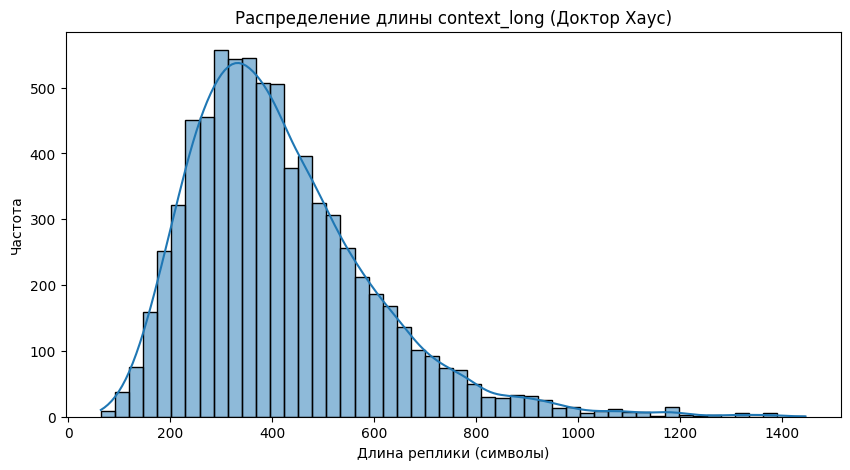

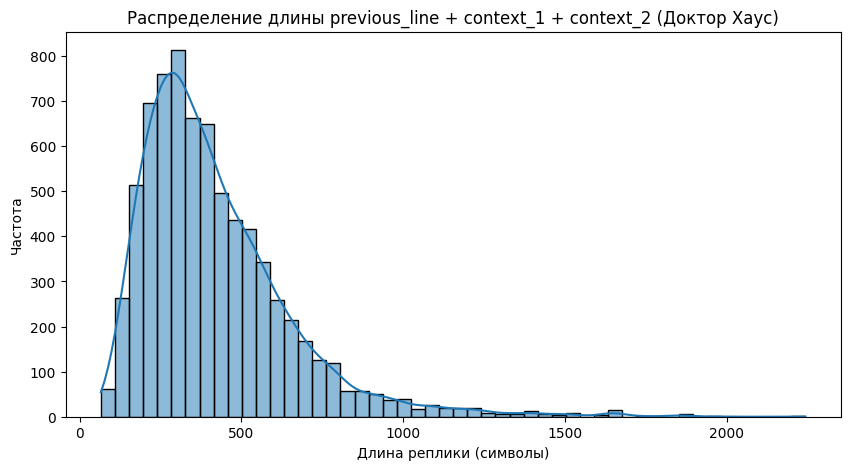

In [72]:
def plot_length_distribution(df, column, title):
    """
    Функция для построения распределения длины реплик в символах.

    df: DataFrame с колонкой текста.
    column: Название колонки, длину которой анализируем.
    title: Заголовок графика.
    """
    lengths = df[column].dropna().apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("Длина реплики (символы)")
    plt.ylabel("Частота")
    plt.title(title)
    plt.show()

# Проверка длины context_long
plot_length_distribution(house_df, "context_long", "Распределение длины context_long (Доктор Хаус)")

# Проверка длины альтернативного варианта: previous_line + context_1 + context_2
house_df["context_combined"] = house_df[["previous_line", "context_1", "context_2"]].fillna("").agg(" ".join, axis=1)
plot_length_distribution(house_df, "context_combined", "Распределение длины previous_line + context_1 + context_2 (Доктор Хаус)")

Статистика длины анкоров после копирования previous_line:
count    7417.00000
mean       10.14251
std         9.81743
min         1.00000
25%         4.00000
50%         7.00000
75%        13.00000
max       152.00000
Name: anchor_length, dtype: float64


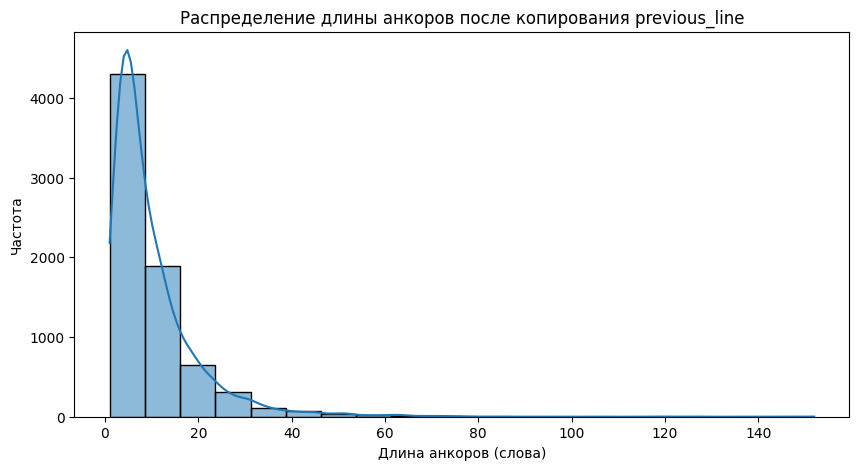

In [74]:
# Копируем предыдущие реплики в анкоры без изменений
house_df["anchor"] = house_df["previous_line"]

# Проверка статистики длины анкоров
house_df["anchor_length"] = house_df["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("Статистика длины анкоров после копирования previous_line:")
print(house_df["anchor_length"].describe())

# Визуализация распределения длины анкоров
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров после копирования previous_line")
plt.show()


In [77]:
# Выбираем 5 самых длинных анкоров
longest_anchors = house_df.nlargest(5, "anchor_length")[["anchor", "line"]]

# Выводим полные тексты
for idx, row in longest_anchors.iterrows():
    print(f"Анкор ({len(row['anchor'].split())} слов): {row['anchor']}")
    print(f"Ответ Хауса: {row['line']}")
    print("-" * 100)

Анкор (152 слов): A few things I forgot to mention. Ed Vogler is a brilliant businessMan. A brilliant Judge of people, and a Man who has nEver lost a fight. You know how I know the new ACE inhibitor is good? Because the old one was good. The new one is really the same, its just more expensive. A lot more expensive. See, thats another example of Eds brilliance. whenever one of his drugs is about to lose its patent he has his boys and girls alter it just a tiny bit and patent it all over again. Making not just a pointless new pill, but millions and millions of dollars. Which is good for Everbody, right? The Patients, pish. Who cares, theyre just so damn sick! God obviously nEver liked them anyway. All the healthy people in the room, lets have a big round of applause for Ed Vogler! I threw in a joke.
Ответ Хауса: Im sorry. I should have taken a couple of extra Vicodin and just held my nose.
---------------------------------------------------------------------------------------------------

In [79]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

# Загружается модель SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

# Проверка наличия нужных колонок
assert "anchor" in house_df.columns, "Колонка 'anchor' отсутствует в house_df"
assert "line" in house_df.columns, "Колонка 'line' отсутствует в house_df"

# Удаление строк, где anchor или line отсутствуют, чтобы сохранить одинаковый размер
valid_rows = house_df.dropna(subset=["anchor", "line"]).reset_index(drop=True)

# Векторизация анкорных реплик и их ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(valid_rows["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(valid_rows["line"].tolist(), convert_to_numpy=True)

# Проверка размеров векторов (они должны быть одинаковыми)
assert anchor_vectors.shape[0] == response_vectors.shape[0], "Размерность анкорных и ответных векторов не совпадает"

# Вычисление косинусного сходства
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(np.diag(similarity_scores))  # Берется диагональ, чтобы сравнить пары

print(f"Среднее косинусное сходство анкорных реплик и их ответов: {avg_similarity:.4f}")


Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и их ответов: 0.2177


In [88]:
import re
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

# Модель SentenceTransformer для векторизации
model = SentenceTransformer("all-mpnet-base-v2")

def count_words(text):
    """Подсчет количества слов в тексте."""
    return len(text.split()) if isinstance(text, str) else 0

def split_sentences(text):
    """Разбивает текст на предложения."""
    return re.split(r'(?<=[.!?])\s+', text.strip())

def extract_relevant_pairs(context, response, min_words=10, max_words=25, similarity_threshold=0.3):
    """
    Извлекает релевантные пары предложений из контекста и ответа.
    Каждая пара состоит из одного предложения из контекста и одного из ответа.
    """
    if not isinstance(context, str) or not isinstance(response, str):
        return []

    context_sentences = split_sentences(context)
    response_sentences = split_sentences(response)

    pairs = []

    for context_sent in context_sentences:
        for response_sent in response_sentences:
            total_words = count_words(context_sent) + count_words(response_sent)
            if 10 <= total_words <= 25:
                # Векторизация попарно, чтобы не забивать память
                context_vec = model.encode([context_sent])[0]
                response_vec = model.encode([response_sent])[0]

                similarity = cosine_similarity([context_vec], [response_vec])[0][0]

                # Порог косинусного сходства для отбора пар
                if similarity >= similarity_threshold:
                    pairs.append({"anchor": context_sent, "line": response_sent, "similarity": float(similarity)})

    return pairs

# Список для новых пар
new_data = []

# 🔹 Берём только 500 строк для теста
sample_size = 50
house_sample = house_df.head(sample_size)

# Проходим по подвыборке
for _, row in tqdm(house_sample.iterrows(), total=len(house_sample), desc="Обработка строк (тест)"):
    context = row.get("context_long", "")
    response = row.get("line", "")

    pairs = extract_relevant_pairs(context, response, similarity_threshold=0.3)

    # Добавляем пары в отдельный список
    for pair in pairs:
        pair["similarity"] = float(pair["similarity"])  # Преобразуем в число
        new_data.append(pair)

# Создание датафрейма с новыми парами
expanded_df_test = pd.DataFrame(new_data)

# ✅ Проверка и удаление строк, где similarity не число
expanded_df_test = expanded_df_test[pd.to_numeric(expanded_df_test["similarity"], errors="coerce").notna()]
expanded_df_test["similarity"] = expanded_df_test["similarity"].astype(float)

# Статистика по итогам теста
if not expanded_df_test.empty:
    avg_similarity = expanded_df_test["similarity"].mean()
    print(f"\nСреднее косинусное сходство новых пар (тест): {avg_similarity:.4f}")

print(f"\nТест: взяли {sample_size} строк из house_df")
print(f"Создано {len(expanded_df_test)} новых пар анкоров")


Обработка строк (тест):   0%|          | 0/50 [00:00<?, ?it/s]


Среднее косинусное сходство новых пар (тест): 0.6582

Тест: взяли 50 строк из house_df
Создано 139 новых пар анкоров


In [91]:
# Запуск полной обработки на всем house_df
new_data_full = []

# Проходим по всему датасету
for _, row in tqdm(house_df.iterrows(), total=len(house_df), desc="Обработка строк (полный запуск)"):
    context = row.get("context_long", "")
    response = row.get("line", "")

    pairs = extract_relevant_pairs(context, response, similarity_threshold=0.3)

    # Добавляем пары в общий список
    for pair in pairs:
        pair["similarity"] = float(pair["similarity"])
        new_data_full.append(pair)

# Создаем расширенный датафрейм
expanded_df_full = pd.DataFrame(new_data_full)

# ✅ Проверяем и удаляем некорректные строки
expanded_df_full = expanded_df_full[pd.to_numeric(expanded_df_full["similarity"], errors="coerce").notna()]
expanded_df_full["similarity"] = expanded_df_full["similarity"].astype(float)

# Вывод статистики
if not expanded_df_full.empty:
    avg_similarity_full = expanded_df_full["similarity"].mean()
    print(f"\nСреднее косинусное сходство новых пар (полный запуск): {avg_similarity_full:.4f}")

print(f"\nИсходный размер датасета: {len(house_df)} строк")
print(f"Создано новых пар: {len(expanded_df_full)}")
print(f"Итоговый размер расширенного датасета: {len(house_df) + len(expanded_df_full)} строк")

# Сохранение результатов в CSV
expanded_df_full.to_csv("/content/expanded_pairs.csv", index=False)

print("\nФайл expanded_pairs.csv сохранен.")


Обработка строк (полный запуск):   0%|          | 0/7417 [00:00<?, ?it/s]


Среднее косинусное сходство новых пар (полный запуск): 0.6866

Исходный размер датасета: 7417 строк
Создано новых пар: 16518
Итоговый размер расширенного датасета: 23935 строк

Файл expanded_pairs.csv сохранен.


In [92]:
expanded_df_full

,anchor,line,similarity
0,"The one who cant talk, I liked that part.","The one who cant talk, I liked that part.",1.000000
1,And shes not responding to radiation treatment.,Is she a doctor,0.343417
2,Your cousin goes to an HMO?,Is she a doctor,0.393680
3,Youve got three overqualified doctors working ...,Is she a doctor,0.408620
4,Is she a doctor?,"No, treating illnesses is why we became doctor...",0.383374
...,...,...,...
16513,All you have to do is create reasonable doubt.,All you have to do is create reasonable doubt.,1.000000
16514,That is a risk you are willing to take.,That is a risk you are willing to take.,1.000000
16515,How to act when youre gone?,How to act when youre gone?,1.000000
16516,Youre the last one I thought would hate me.,Youre the last one I thought would hate me.,1.000000


In [94]:
# Удаление полных копий
expanded_df_full = expanded_df_full[expanded_df_full["anchor"] != expanded_df_full["line"]].reset_index(drop=True)

# Вывод новой статистики
print(f"После удаления копий осталось: {len(expanded_df_full)} строк")

После удаления копий осталось: 9335 строк


Статистика длины ответов после обрезки до 30 слов:
count    9335.000000
mean        8.190252
std         3.692430
min         1.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        23.000000
Name: line, dtype: float64


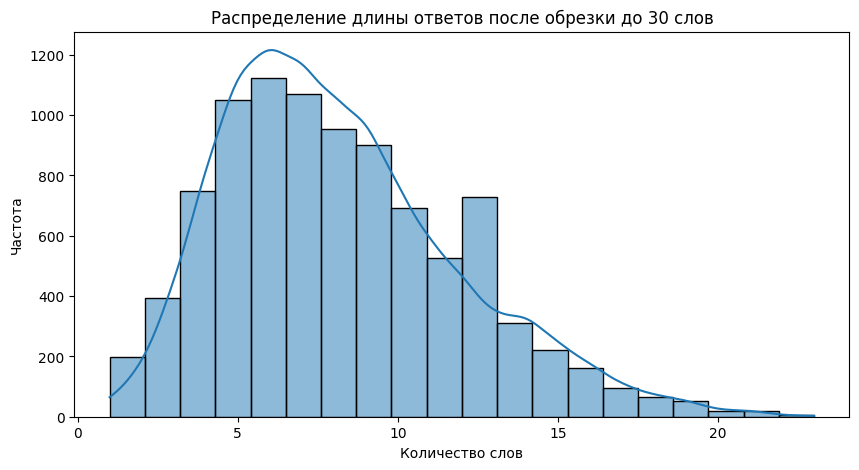

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Обрезка длинных реплик Хауса (больше 30 слов)
MAX_WORDS = 30

def truncate_text(text, max_words=MAX_LINE_LENGTH):
    words = text.split()
    return " ".join(words[:max_words]) if len(words) > max_words else text

expanded_df_full["line"] = expanded_df_full["line"].apply(lambda x: truncate_text(x) if isinstance(x, str) else x)

# Вывод статистики без дополнительной колонки
lengths = expanded_df_full["line"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("Статистика длины ответов после обрезки до 30 слов:")
print(lengths.describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=20, kde=True)
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.title("Распределение длины ответов после обрезки до 30 слов")
plt.show()


Статистика длины анкоров после обрезки до 20 последних слов:
count    9335.000000
mean        7.800000
std         3.591791
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        20.000000
Name: anchor, dtype: float64


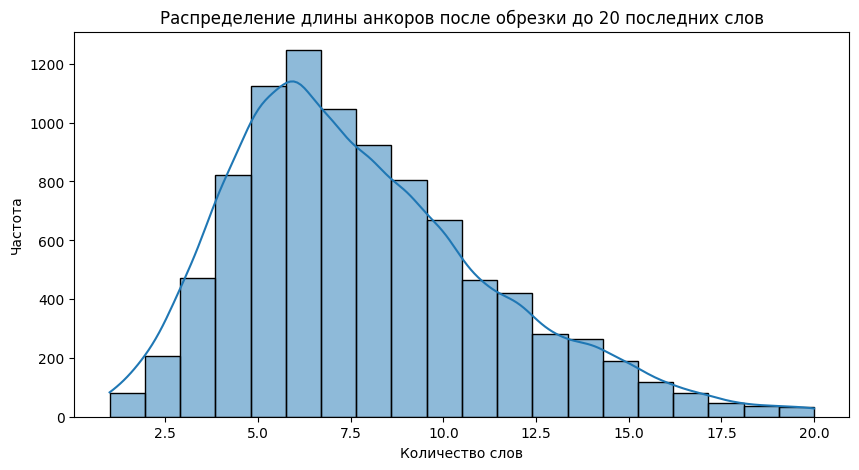

In [97]:
MAX_ANCHOR_LENGTH = 20  # Максимальная длина анкоров (последних слов)

def truncate_anchor_last_words(text, max_words=MAX_ANCHOR_LENGTH):
    words = text.split()
    if len(words) <= max_words:
        return text
    # Оставляем только последние слова
    return " ".join(words[-max_words:])

# Создание колонки anchor и копирование предыдущих реплик
expanded_df_full["anchor"] = expanded_df_full["anchor"].apply(lambda x: truncate_anchor_last_words(x) if isinstance(x, str) else x)

# Проверка статистики
anchor_lengths = expanded_df_full["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("Статистика длины анкоров после обрезки до 20 последних слов:")
print(anchor_lengths.describe())

# Визуализация распределения длины анкоров
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(anchor_lengths, bins=20, kde=True)
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров после обрезки до 20 последних слов")
plt.show()


In [100]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

# Загружается модель SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

# Проверка наличия нужных колонок
assert "anchor" in expanded_df_full.columns, "Колонка 'anchor' отсутствует в expanded_df_full"
assert "line" in expanded_df_full.columns, "Колонка 'line' отсутствует в expanded_df_full"

# Удаление строк, где anchor или line отсутствуют, чтобы сохранить одинаковый размер
valid_rows = expanded_df_full.dropna(subset=["anchor", "line"]).reset_index(drop=True)

# Векторизация анкорных реплик и их ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(valid_rows["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(valid_rows["line"].tolist(), convert_to_numpy=True)

# Проверка размеров векторов (они должны быть одинаковыми)
assert anchor_vectors.shape[0] == response_vectors.shape[0], "Размерность анкорных и ответных векторов не совпадает"

# Вычисление косинусного сходства
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(np.diag(similarity_scores))  # Берется диагональ, чтобы сравнить пары

print(f"Среднее косинусное сходство анкорных реплик и их ответов: {avg_similarity:.4f}")


Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и их ответов: 0.4454


In [103]:
# Удаление строк, где ответ содержится в анкоре
expanded_df_full = expanded_df_full[~expanded_df_full["answer_in_anchor"]].reset_index(drop=True)

# Итоговая статистика
print(f"Обновленный размер датасета после удаления: {len(expanded_df_full)} строк")

Обновленный размер датасета после удаления: 8674 строк


In [105]:
import numpy as np

threshold_lower = 0.05  # Ослабляем нижний порог
threshold_upper = 0.2   # Уменьшаем верхний порог
top_k = 50  # Расширяем выборку для негативных примеров

# Преобразование DataFrame в массивы
antagonist_lines = antagonists_df["line"].values
similarities_np = np.array(similarities)

# Создание списка для негативных примеров (с учетом расширенного датасета)
new_hard_negatives = np.full(len(expanded_df_full), "", dtype=object)

for i in range(similarities_np.shape[0]):
    sorted_idx = np.argsort(similarities_np[i])[::-1]  # Сортировка по убыванию
    candidates = sorted_idx[
        (similarities_np[i][sorted_idx] > threshold_lower) &
        (similarities_np[i][sorted_idx] < threshold_upper)
    ]  # Фильтрация слишком легких и слишком похожих примеров

    if len(candidates) > 5:
        neg_idx = np.random.choice(candidates[:top_k])  # Выбираем случайный из top-k
        new_hard_negatives[i] = antagonist_lines[neg_idx]

# ✅ Добавляем в expanded_df_full колонку с негативными ответами
expanded_df_full["neg_answer"] = new_hard_negatives[:len(expanded_df_full)]  # Подгоняем длину
print(f"Обновлено {len(new_hard_negatives)} негативных примеров.")

# === Теперь создаем триплеты ===
triplets_df = expanded_df_full[["anchor", "line", "neg_answer"]].copy()
triplets_df.columns = ["anchor", "response", "neg_response"]  # Переименовываем для единообразия

print(f"Создано {len(triplets_df)} триплетов.")

# Проверка на NaN
assert triplets_df.isna().sum().sum() == 0, "Есть NaN в триплетах!"

# ✅ Вывод статистики
print("\nТриплеты успешно созданы.")
print(triplets_df.head())


Обновлено 8674 негативных примеров.
Создано 8674 триплетов.

Триплеты успешно созданы.
                                              anchor  \
0    And shes not responding to radiation treatment.   
1                        Your cousin goes to an HMO?   
2  Youve got three overqualified doctors working ...   
3                                   Is she a doctor?   
4                                                Dr.   

                                            response neg_response  
0                                    Is she a doctor               
1                                    Is she a doctor               
2                                    Is she a doctor               
3  No, treating illnesses is why we became doctor...               
4  No, treating illnesses is why we became doctor...               


Sentences: 3, Similarities shape: (3,)
Sentences: 2, Similarities shape: (2,)
Sentences: 5, Similarities shape: (5,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 2, Similarities shape: (2,)
Sentences: 7, Similarities shape: (7,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 1, Similarities shape: (1,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 3, Similarities shape: (3,)
Sentences: 4, Similarities shape: (4,)
Sentences: 1, Similarities shape: (1,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 8, Similaritie

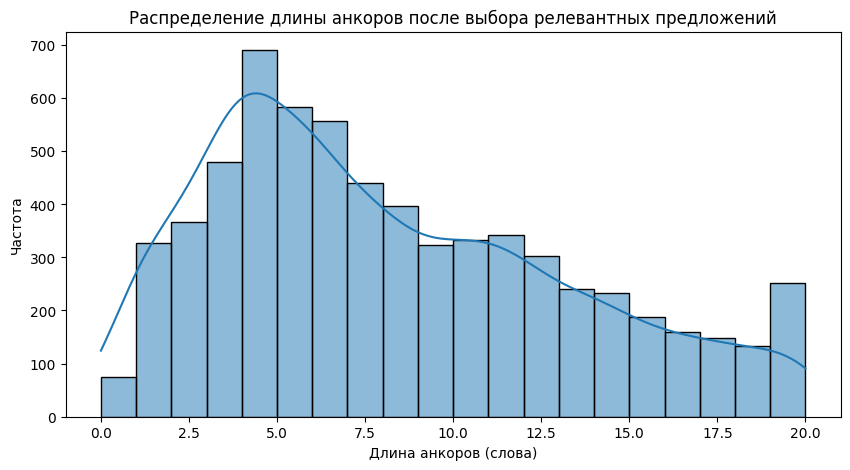

In [28]:
def count_words(text):
    """Подсчет количества слов в тексте."""
    return len(text.split()) if isinstance(text, str) else 0

def split_sentences(text):
    """Разбивает текст на предложения с учетом знаков препинания."""
    return re.split(r'(?<=[.!?])\s+', text.strip())

def select_best_sentences(row, min_words=10, max_words=20):
    """
    Выбирает 1-3 наиболее релевантных предложения из `previous_line`
    на основе косинусного сходства с `line` (ответом).
    """
    text = row.get("previous_line", "")
    response = row.get("line", "")

    if not isinstance(text, str) or len(text) == 0:
        return None

    # Разделяем предыдущую реплику на предложения
    sentences = split_sentences(text)
    if len(sentences) == 0:
        return None  # Если предложений нет, вернуть пустой анкор

    # Векторизуем предложения и сам ответ
    try:
        sentences_vectors = model.encode(sentences, convert_to_numpy=True)
        response_vector = model.encode([response], convert_to_numpy=True)[0]  # Извлекаем первый вектор
    except Exception as e:
        print(f"Ошибка векторизации: {e}")
        return None

    # Вычисляем косинусное сходство
    similarities = cosine_similarity(sentences_vectors, [response_vector]).flatten()

    # Отладка: проверить размеры массивов
    print(f"Sentences: {len(sentences)}, Similarities shape: {similarities.shape}")

    # Если similarities имеет 0-мерную форму (скаляр), значит, произошла ошибка
    if similarities.ndim == 0:
        print("Ошибка: similarities имеет 0-мерную форму (скаляр).")
        return None

    # Сортируем предложения по убыванию схожести
    ranked_sentences = sorted(zip(sentences, similarities), key=lambda x: x[1], reverse=True)

    # Выбираем 1-3 наиболее релевантных предложения, пока не достигнем min_words
    selected_sentences = []
    total_words = 0
    for sent, _ in ranked_sentences:
        words = sent.split()
        if total_words + len(words) > max_words:
            break
        selected_sentences.append(sent)
        total_words += len(words)
        if total_words >= min_words:
            break

    return " ".join(selected_sentences) if selected_sentences else None

# Применяем метод только к длинным репликам
mask_long_anchors = house_df["previous_line"].apply(count_words) > 20
house_df.loc[mask_long_anchors, "anchor"] = house_df[mask_long_anchors].apply(select_best_sentences, axis=1)

# Проверяем статистику
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print("Статистика длины анкоров после выбора релевантных предложений:")
print(house_df["anchor_length"].describe())

# Визуализация распределения
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров после выбора релевантных предложений")
plt.show()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Проверка наличия нужных колонок
assert "anchor" in house_df.columns, "Колонка 'anchor' отсутствует в house_df"
assert "line" in house_df.columns, "Колонка 'line' отсутствует в house_df"

# Векторизация анкорных реплик и их ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(house_df["anchor"].dropna().tolist(), convert_to_numpy=True)
response_vectors = model.encode(house_df["line"].dropna().tolist(), convert_to_numpy=True)

# Вычисление косинусного сходства
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(similarity_scores.diagonal())

print(f"Среднее косинусное сходство анкорных реплик и их ответов: {avg_similarity:.4f}")


Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и их ответов: 0.1072


Статистика длины анкоров после заполнения из последнего предложения:
count    6598.000000
mean        8.543498
std         4.560526
min         3.000000
25%         5.000000
50%         7.000000
75%        11.000000
max        20.000000
Name: anchor_length, dtype: float64


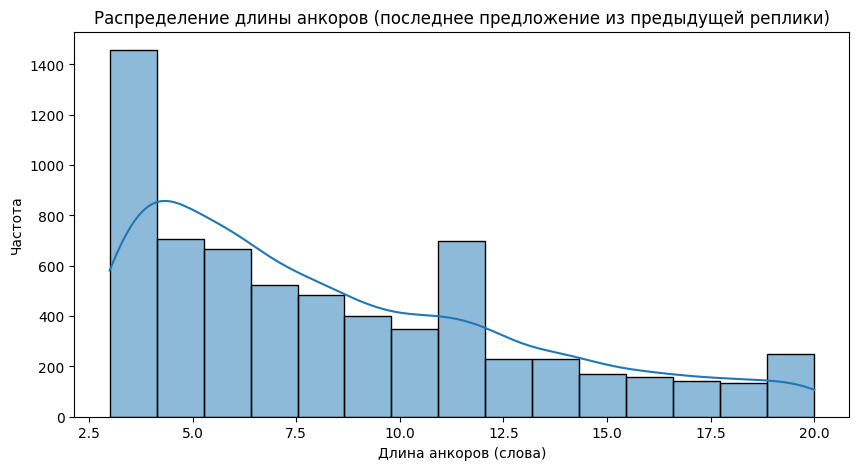

Заполнено 6598 анкоров из 8329 строк после доработки.


In [75]:
# Создаём колонку 'anchor', если её нет
if "anchor" not in house_df.columns:
    house_df["anchor"] = None

# Применение к строкам, где anchor не заполнен и previous_line > 20 слов
mask = house_df["anchor"].isna() & (house_df["previous_line"].apply(count_words) > 20)
house_df.loc[mask, "anchor"] = house_df.loc[mask, "previous_line"].apply(extract_last_sentence)

# Вывод статистики
house_df["anchor_length"] = house_df["anchor"].dropna().apply(count_words)
print("Статистика длины анкоров после заполнения из последнего предложения:")
print(house_df["anchor_length"].describe())

# Визуализация распределения длины анкоров
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=15, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров (последнее предложение из предыдущей реплики)")
plt.show()

# Подсчет количества заполненных анкоров
num_filled = house_df["anchor"].notna().sum()
num_total = len(house_df)
print(f"Заполнено {num_filled} анкоров из {num_total} строк после доработки.")


Статистика длины previous_line у строк с пустым анкором:
count    1731.000000
mean       16.600809
std        18.119245
min         0.000000
25%         2.000000
50%         2.000000
75%        27.500000
max       152.000000
Name: previous_line, dtype: float64


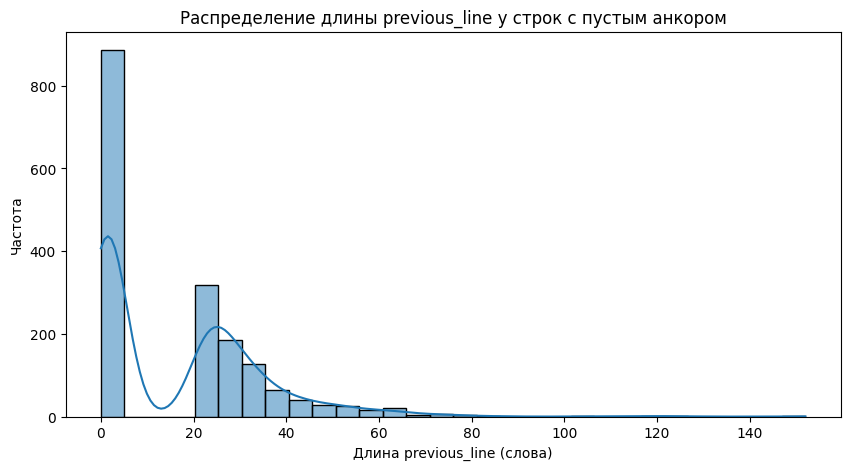

In [76]:
# Фильтрация строк с пустым анкором
empty_anchor_mask = house_df["anchor"].isna()
empty_previous_lengths = house_df.loc[empty_anchor_mask, "previous_line"].dropna().apply(lambda x: len(x.split()))

# Вывод статистики
print("Статистика длины previous_line у строк с пустым анкором:")
print(empty_previous_lengths.describe())

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.histplot(empty_previous_lengths, bins=30, kde=True)
plt.xlabel("Длина previous_line (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины previous_line у строк с пустым анкором")
plt.show()


Статистика длины анкоров после заполнения последними предложениями из previous_line:
count    8329.000000
mean        7.848481
std         4.889126
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        20.000000
Name: anchor_length, dtype: float64


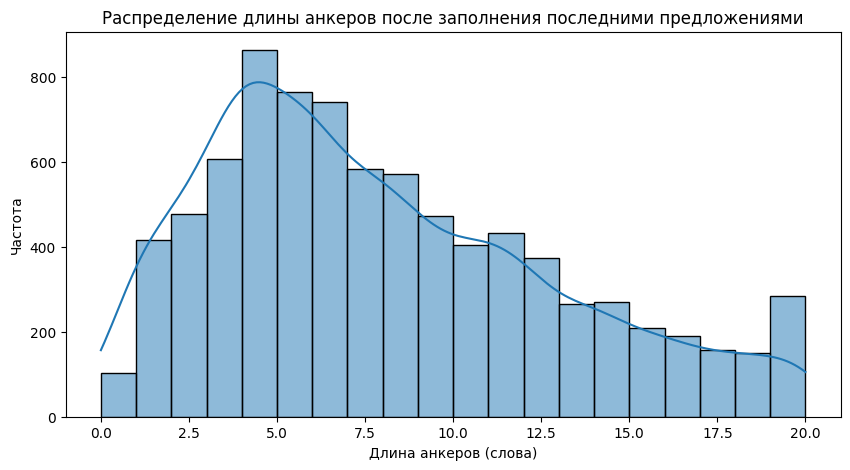

In [77]:
import re

def extract_last_sentences(text, min_words=5, max_words=20):
    """
    Берет 1-3 последних предложения из текста, чтобы получить от 5 до 20 слов.
    """
    if not isinstance(text, str) or len(text) == 0:
        return None

    # Разбиваем текст на предложения с учетом пунктуации
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    # Начинаем собирать предложения с конца
    selected_sentences = []
    total_words = 0

    for sent in reversed(sentences):  # Двигаемся от последнего предложения
        words = sent.split()

        if total_words + len(words) > max_words:
            break  # Если превышаем max_words, останавливаемся

        selected_sentences.append(sent)
        total_words += len(words)

        if total_words >= min_words:
            break  # Как только набрали min_words, останавливаемся

    # Склеиваем предложения в правильном порядке
    return " ".join(reversed(selected_sentences)).strip() if selected_sentences else None

# Заполняем пустые анкоры
empty_anchor_mask = house_df["anchor"].isna()
house_df.loc[empty_anchor_mask, "anchor"] = house_df.loc[empty_anchor_mask, "previous_line"].apply(extract_last_sentences)

# Проверка статистики
house_df["anchor_length"] = house_df["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("Статистика длины анкоров после заполнения последними предложениями из previous_line:")
print(house_df["anchor_length"].describe())

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("Длина анкеров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкеров после заполнения последними предложениями")
plt.show()


In [78]:
nan_count = house_df["anchor"].isna().sum()
print(f"Количество NaN в колонке 'anchor': {nan_count}")


Количество NaN в колонке 'anchor': 102


In [79]:
def fill_remaining_anchors(row, max_words=20):
    """
    Если анкор все еще NaN, заполняем его полностью previous_line или context_1 + previous_line.
    """
    previous = row.get("previous_line", "")
    context = row.get("context_1", "")

    if not isinstance(previous, str):
        previous = ""
    if not isinstance(context, str):
        context = ""

    # Если previous_line не слишком длинный, берем его полностью
    if 5 <= len(previous.split()) <= max_words:
        return previous

    # Если previous_line короткий, добавляем context_1 (если он есть и не дублируется)
    if context and previous and context not in previous:
        combined_text = f"{context} {previous}"
    else:
        combined_text = previous

    # Проверяем длину полученного анкера
    words = combined_text.split()
    return " ".join(words[:max_words]) if len(words) > max_words else combined_text

# Заполняем оставшиеся NaN
house_df.loc[house_df["anchor"].isna(), "anchor"] = house_df[house_df["anchor"].isna()].apply(fill_remaining_anchors, axis=1)

# Проверка, остались ли NaN
nan_count_after = house_df["anchor"].isna().sum()
print(f"Осталось NaN после заполнения: {nan_count_after}")


Осталось NaN после заполнения: 0


Статистика формирования анкоров:
- Simple copy: 59
- Truncated: 0
- Context 1 added: 1571
- Context 2 added: 3026
- Context 3 added: 1391
- Context 4 added: 273
- Context 5 added: 21
- Prev in context ignored: 16
- Problematic cases: 0
- Response removed: 16
- Response removed after context: 12922


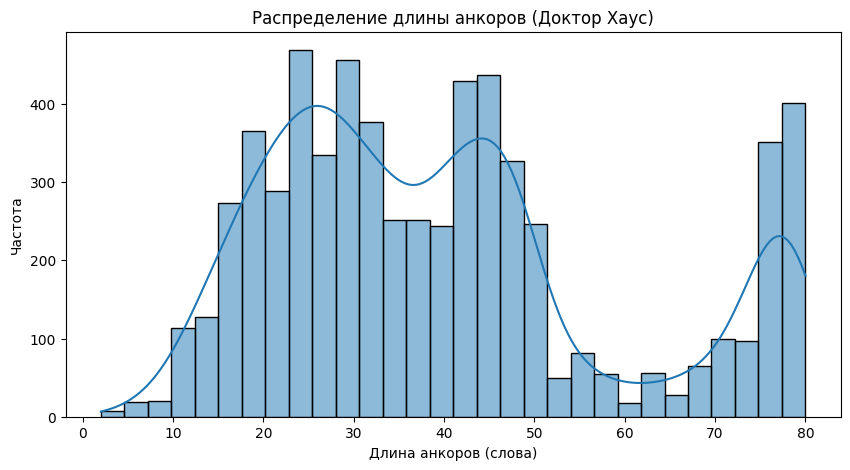

In [12]:
# Функция для подсчета слов
def count_words(text):
    return len(text.split())

# Функция для разделения на предложения
def split_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

# Статистика по способу создания анкоров
stats = {
    "simple_copy": 0,
    "truncated": 0,
    "context_1_added": 0,
    "context_2_added": 0,
    "context_3_added": 0,
    "context_4_added": 0,
    "context_5_added": 0,
    "prev_in_context_ignored": 0,
    "problematic_cases": 0,
    "response_removed": 0,
    "response_removed_after_context": 0  # Добавлен ключ
}

# Списки для проблемных случаев
long_unprocessed = []  # Длинные previous_line, которые не удалось обрезать
short_unprocessed = []  # Короткие, которым не хватило контекста


def truncate_long_anchor(text, max_words=75):
    """Обрезает анкор до `max_words`, начиная с конца."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    sentences = split_sentences(text)  # Разбивает на предложения
    truncated_text = ""

    # Добавляем предложения с конца, пока не достигнем `max_words`
    for i in range(len(sentences) - 1, -1, -1):
        truncated_text = " ".join(sentences[i:] + [truncated_text]).strip()
        if count_words(truncated_text) <= max_words:
            return truncated_text

    return truncated_text  # Если ничего не подошло, оставляем как есть

# Функция объединения коротких предложений
def merge_short_sentences(sentences, min_length=5):
    """Объединяет слишком короткие предложения с соседними."""
    merged_sentences = []
    buffer = ""

    for sent in sentences:
        if len(sent.split()) < min_length:  # Если предложение короткое
            buffer += " " + sent  # Добавляем в буфер
        else:
            if buffer:
                merged_sentences.append(buffer.strip() + " " + sent)  # Объединяем с предыдущими
                buffer = ""  # Очищаем буфер
            else:
                merged_sentences.append(sent)  # Добавляем нормальное предложение

    # Проверяем, есть ли данные в merged_sentences перед добавлением buffer
    if buffer and merged_sentences:
        merged_sentences[-1] += " " + buffer  # Добавляем оставшийся буфер к последнему предложению
    elif buffer:  # Если buffer есть, но merged_sentences пуст, просто добавляем buffer
        merged_sentences.append(buffer.strip())

    return merged_sentences

def remove_duplicate_sentences(text):
    """Удаляет повторяющиеся предложения в тексте."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    sentences = split_sentences(text)  # Разбивает на предложения
    unique_sentences = list(dict.fromkeys(sentences))  # Убирает дубликаты, сохраняя порядок
    return " ".join(unique_sentences)

# Функция создания анкоров с учетом коротких предложений
def create_anchor(row):
    """Создает анкорную реплику с учетом контекста, удаления дубликатов и коротких предложений."""
    min_words, max_words = 50, 75
    soft_min, soft_max = 40, 80
    previous = row.get("previous_line", "")
    response = row.get("line", "")
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    # Если previous_line уже есть в context_1, заменяется
    if pd.notna(row["context_1"]) and pd.notna(previous) and previous in row["context_1"]:
        previous = row["context_1"]
        stats["prev_in_context_ignored"] += 1

    # Проверка наличия текста
    if pd.isna(previous) or count_words(previous) == 0:
        stats["problematic_cases"] += 1
        short_unprocessed.append(row.to_dict())
        return None

    # Удаление `response` из `previous`
    if response in previous:
        previous = previous.replace(response, "").strip()
        stats["response_removed"] += 1

    # Очистка повторяющихся предложений
    previous = remove_duplicate_sentences(previous)

    # Разбиение на предложения и обработка коротких
    sentences = split_sentences(previous)
    sentences = merge_short_sentences(sentences)

    # Объединение в текст
    previous = " ".join(sentences)
    words_count = count_words(previous)

    # Проверка длины после очистки
    if min_words <= words_count <= max_words:
        stats["simple_copy"] += 1
        return previous

    # Если слишком длинный, отсекаем последние предложения
    if words_count > max_words:
        previous = truncate_long_anchor(previous)
        words_count = count_words(previous)

    # Если previous_line короткий, добавляется контекст
    full_context = [previous]

    for i, col in enumerate(context_columns, start=1):
        if col in row and pd.notna(row[col]):
            full_context.append(row[col])
            combined_text = " ".join(full_context)
            combined_words = count_words(combined_text)

            # Очистка повторов и удаления `response`
            combined_text = remove_duplicate_sentences(combined_text)
            if response in combined_text:
                combined_text = combined_text.replace(response, "").strip()
                stats["response_removed_after_context"] += 1

            if min_words <= combined_words <= max_words:
                stats[f"context_{i}_added"] += 1
                return combined_text

            if combined_words > soft_max:
                prev_words = count_words(" ".join(full_context[:-1]))
                if soft_min <= prev_words <= soft_max:
                    stats[f"context_{i}_added"] += 1
                    return " ".join(full_context[:-1])

                # Обрезка последнего добавленного контекста
                sentences = split_sentences(row[col])
                sentences = merge_short_sentences(sentences)  # Объединение коротких
                for j in range(len(sentences) - 1, -1, -1):
                    truncated_text = " ".join(full_context[:-1]) + " " + " ".join(sentences[:j])
                    truncated_words = count_words(truncated_text)

                    if soft_min <= truncated_words <= soft_max:
                        stats[f"context_{i}_added"] += 1
                        return truncated_text

                stats["problematic_cases"] += 1
                short_unprocessed.append(row.to_dict())
                return None

    stats["problematic_cases"] += 1
    short_unprocessed.append(row.to_dict())
    return None

# Применение обновленного метода
house_df["anchor"] = house_df.apply(create_anchor, axis=1)

# Вывод статистики
print("Статистика формирования анкоров:")
for key, value in stats.items():
    print(f"- {key.replace('_', ' ').capitalize()}: {value}")

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor"].dropna().apply(count_words), bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров (Доктор Хаус)")
plt.show()


Обновленная статистика длины анкоров:
count    6341.000000
mean       73.389213
std        23.576640
min         3.000000
25%        56.000000
50%        72.000000
75%        82.000000
max       227.000000
Name: anchor_length, dtype: float64


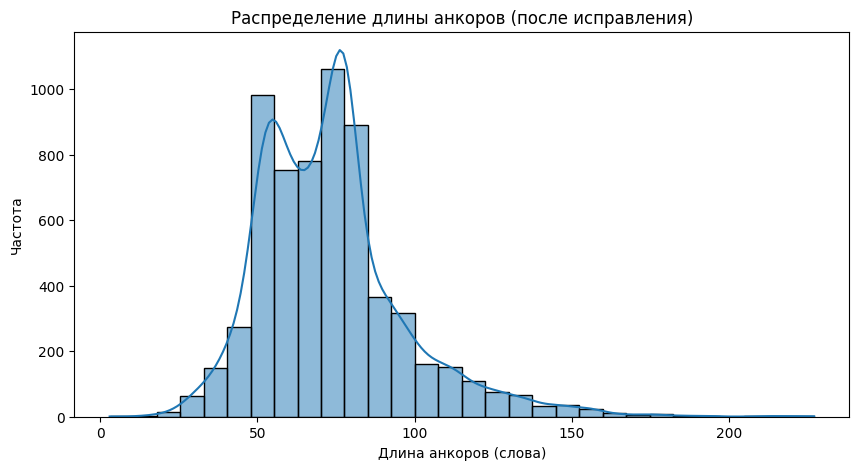

In [13]:
def improve_short_anchors(row, min_words=50):
    """Дополняет короткие анкоры контекстом, удаляет повторения и ответ."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")  # Длинный контекст

    # Если анкор уже достаточно длинный, оставляем как есть
    if count_words(anchor) >= min_words:
        return anchor

    # Добавляем контекст, если он есть
    if pd.notna(context_long):
        anchor += " " + context_long

    # Удаление дубликатов
    anchor = remove_duplicate_sentences(anchor)

    # Удаление ответа, если он попал в анкор
    if response in anchor:
        anchor = anchor.replace(response, "").strip()

    # Повторная проверка длины
    if count_words(anchor) < min_words and pd.notna(row["previous_line"]):
        anchor = row["previous_line"] + " " + anchor

    return anchor

# Применение улучшения к коротким анкорам
house_df["anchor"] = house_df.apply(improve_short_anchors, axis=1)

# Повторная проверка статистики
print("Обновленная статистика длины анкоров:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров (после исправления)")
plt.show()

Обновленная статистика длины анкоров:
count    6341.000000
mean       70.606214
std        18.644676
min        15.000000
25%        58.000000
50%        71.000000
75%        80.000000
max       282.000000
Name: anchor_length, dtype: float64


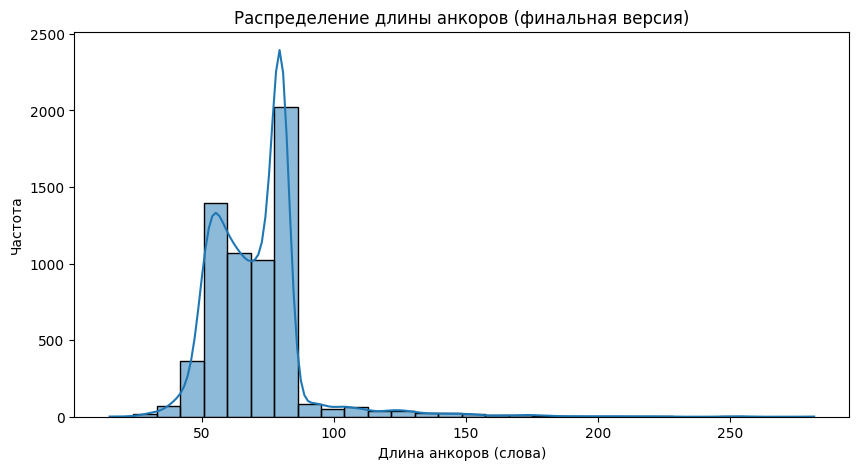

In [14]:
def truncate_long_anchor(text, max_words=80):
    """Обрезает анкор до `max_words`, начиная с начала, чтобы сохранить последние предложения."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    words = text.split()
    if len(words) > max_words:
        return " ".join(words[-max_words:])  # Берем последние `max_words` слов

    return text  # Если текст уже в пределах нормы, не обрезаем

def improve_anchor(row, min_words=50, max_words=80):
    """Оптимизирует анкоры: сокращает длинные, добавляет контекст для коротких, удаляет повторы и ответы."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")  # Длинный контекст

    # Удаление дубликатов
    anchor = remove_duplicate_sentences(anchor)

    # Удаление ответа, заменяя на "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # Обрезка слишком длинных анкоров (берем последние 80 слов)
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # Если анкор слишком короткий, добавляем контекст
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

    return anchor

# Применение улучшений к анкорам
house_df["anchor"] = house_df.apply(improve_anchor, axis=1)

# Повторная проверка статистики
print("Обновленная статистика длины анкоров:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров (финальная версия)")
plt.show()


Финальная статистика длины анкоров:
count    6341.000000
mean       66.114493
std        13.148874
min        16.000000
25%        54.000000
50%        68.000000
75%        80.000000
max        80.000000
Name: anchor_length, dtype: float64


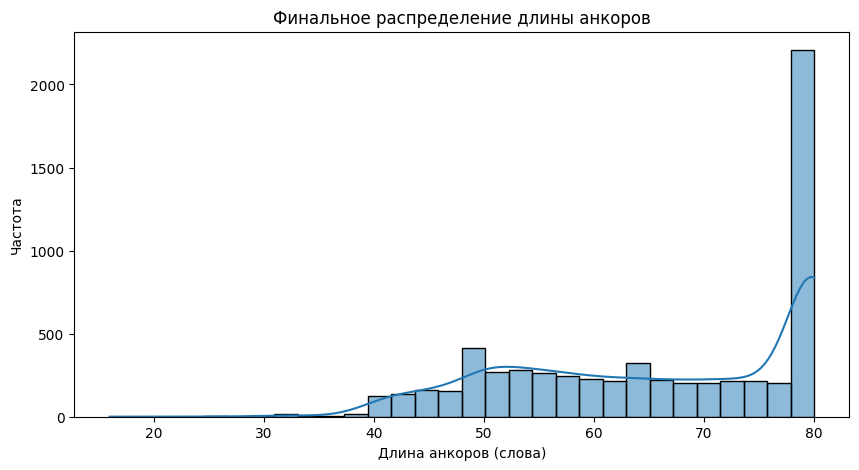

In [15]:
def truncate_long_anchor(text, max_words=80):
    """Обрезает анкор до `max_words`, начиная с начала, чтобы сохранить последние предложения."""
    words = text.split()
    return " ".join(words[-max_words:]) if len(words) > max_words else text

def improve_anchor(row, min_words=40, max_words=80):
    """Оптимизирует анкоры: сокращает длинные, добавляет контекст для коротких, удаляет повторы и ответы."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")

    # Удаление дубликатов
    anchor = remove_duplicate_sentences(anchor)

    # Удаление ответа, заменяя на "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # Обрезка слишком длинных анкоров
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # Если анкор слишком короткий, добавляется контекст
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

        # Повторная проверка после добавления контекста
        if count_words(anchor) > max_words:
            anchor = truncate_long_anchor(anchor, max_words)

    return anchor

# Применение финальной версии улучшения анкоров
house_df["anchor"] = house_df.apply(improve_anchor, axis=1)

# Повторная проверка статистики
print("Финальная статистика длины анкоров:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Финальное распределение длины анкоров")
plt.show()

Финальная статистика длины анкоров (с корректировкой min/max):
count    6341.000000
mean       65.580192
std        13.786214
min        16.000000
25%        54.000000
50%        68.000000
75%        80.000000
max        85.000000
Name: anchor_length, dtype: float64


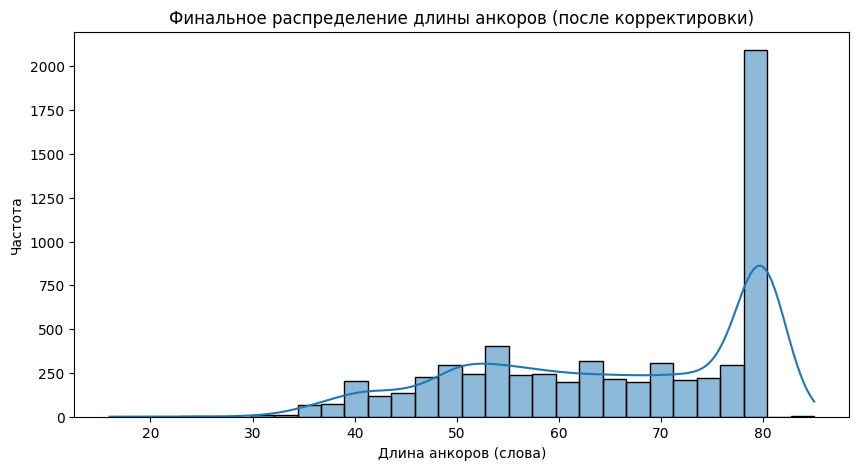

In [16]:
def improve_anchor_final(row, min_words=35, max_words=85):
    """Гарантирует, что анкоры будут в пределах от min_words до max_words."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")

    # Удаление дубликатов
    anchor = remove_duplicate_sentences(anchor)

    # Удаление ответа, заменяя на "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # Обрезка слишком длинных анкоров
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # Если анкор слишком короткий, добавляется контекст
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

        # Повторная проверка после добавления контекста
        if count_words(anchor) > max_words:
            anchor = truncate_long_anchor(anchor, max_words)

    return anchor

# Применение финального улучшения
house_df["anchor"] = house_df.apply(improve_anchor_final, axis=1)

# Проверка статистики после финального исправления
print("Финальная статистика длины анкоров (с корректировкой min/max):")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Финальное распределение длины анкоров (после корректировки)")
plt.show()


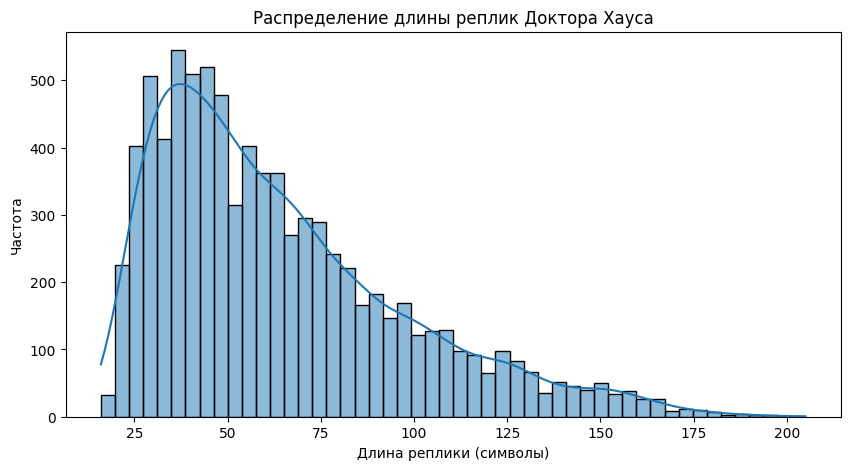

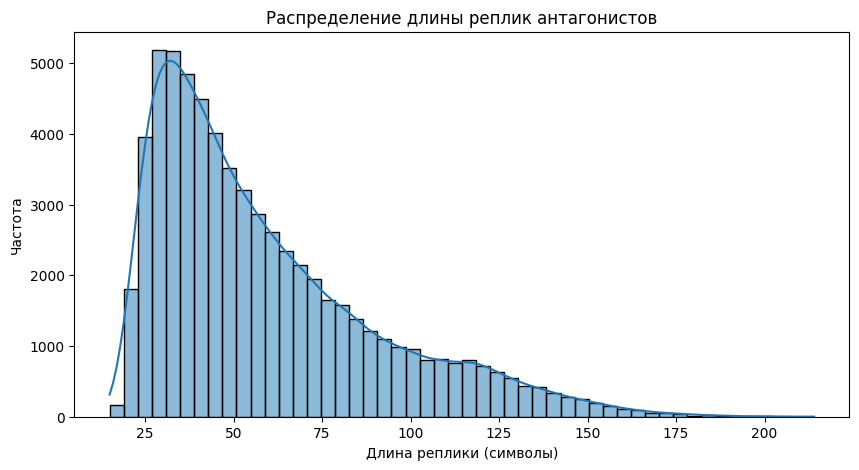

In [80]:
def plot_length_distribution(df, title):
    """
    Функция для построения распределения длины реплик.

    df: DataFrame с колонкой "line".
    title: Заголовок графика.
    """
    lengths = df["line"].apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("Длина реплики (символы)")
    plt.ylabel("Частота")
    plt.title(title)
    plt.show()

# Построение графиков
plot_length_distribution(house_df, "Распределение длины реплик Доктора Хауса")
plot_length_distribution(antagonists_df, "Распределение длины реплик антагонистов")

In [81]:
# Параметры предобработки
MIN_WORDS = 5  # Минимальная длина реплики
MAX_WORDS = 30  # Максимальная длина после разбиения на чанки

def clean_text(text):
    """Повторная очистка текста от проблемных символов, лишних пробелов и эмодзи."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    text = text.replace("�", "")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^\x00-\x7F]+", "", text)

    return text

def split_into_chunks(text, min_words=MIN_WORDS, max_words=MAX_WORDS):
    """
    Разбивает текст на чанки, с приоритетом разбиения по точке (.), затем по !?.
    Если предложение слишком длинное, делится на равные части, но не менее min_words в чанке.
    """
    if not isinstance(text, str) or len(text) == 0:
        return []

    # Разделение с приоритетом: сначала `.`, затем `!?`
    sentences = re.split(r'([.])\s+', text)  # Сначала по точке
    sentences = ["".join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]
    sentences = sum([re.split(r'([!?])\s+', s) for s in sentences], [])  # Дополнительно по `!?`
    sentences = ["".join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]

    # Объединение слишком коротких предложений
    chunks = []
    buffer = []

    for sentence in sentences:
        words = sentence.split()

        if len(words) > max_words:  # Если предложение > max_words, делим вручную
            for i in range(0, len(words), max_words):
                chunks.append(" ".join(words[i:i + max_words]))
        else:
            buffer.extend(words)

            if len(buffer) >= min_words:  # Если накопили достаточно слов, фиксируем чанк
                chunks.append(" ".join(buffer))
                buffer = []

    if buffer:
        chunks.append(" ".join(buffer))

    return chunks

def process_dataframe(df, name):
    """
    Обработка датафрейма, заменяя длинные реплики их чанками.
    """
    initial_count = len(df)
    avg_length_before = df["line"].str.split().str.len().mean()

    # Определение слишком коротких реплик
    df["num_words"] = df["line"].str.split().str.len()
    long_replies = df[df["num_words"] > MAX_WORDS]
    short_replies = df[df["num_words"] <= MAX_WORDS]

    print(f"\nОбработка {name}: Исходное количество строк: {initial_count}")
    print(f"Средняя длина реплики до разбиения: {avg_length_before:.2f} слов")
    print(f"Реплик длиннее {MAX_WORDS} слов: {len(long_replies)}")

    # Разделение длинных строки на чанки, сохраняя все данные строки
    expanded_data = []
    for _, row in long_replies.iterrows():
        text_chunks = split_into_chunks(row["line"])
        for chunk in text_chunks:
            if len(chunk.split()) >= MIN_WORDS:  # Исключаем слишком короткие чанки
                new_row = row.copy()
                new_row["line"] = chunk
                expanded_data.append(new_row)

    # Создание нового датафрейма с обновленными репликами
    expanded_df = pd.DataFrame(expanded_data)

    # Объединение коротких и разделенных реплик
    df = pd.concat([short_replies, expanded_df], ignore_index=True)

    # Удаление реплик менее 5 слов
    df = df[df["line"].str.split().str.len() >= MIN_WORDS].reset_index(drop=True)

    # Финальные вычисления
    final_count = len(df)
    avg_length_after = df["line"].str.split().str.len().mean()
    num_new_rows = final_count - initial_count

    print(f"\nОбработка {name}:")
    print(f"- Длина датафрейма до разбиения: {initial_count}")
    print(f"- Количество новых строк: {num_new_rows}")
    print(f"- Итоговое количество строк: {final_count}")
    print(f"- Средняя длина реплики после разбиения: {avg_length_after:.2f} слов")

    # Проверка, остались ли еще длинные реплики после разбиения
    long_after = df[df["line"].str.split().str.len() > MAX_WORDS]
    if not long_after.empty:
        print("\nОстались реплики длиннее 30 слов! Принудительное разбиение:")
        df["line"] = df["line"].apply(lambda text: split_into_chunks(text, min_words=MIN_WORDS, max_words=MAX_WORDS))
        df = df.explode("line").reset_index(drop=True)
        df = df[df["line"].str.split().str.len() >= MIN_WORDS]
        print("Все реплики теперь < 30 слов.")

    # Удаление ненужных столбцов
    df = df.drop(columns=["num_words"])

    return df

# Очистка данных перед разбиением
def preprocess_dataframe(df, text_column="line", group_by_character=True):
    """Очистка данных: удаление пустых строк, коротких реплик, вопросов, дубликатов и подозрительных символов"""

    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    df[text_column] = df[text_column].apply(clean_text)

    # Удаление слишком коротких реплик
    df = df[df[text_column].str.split().str.len() >= MIN_WORDS].reset_index(drop=True)

    # Удаление дубликатов
    df = df.drop_duplicates(subset=[text_column]).reset_index(drop=True)

    return df

# Чистим и обрабатываем данные
house_df = preprocess_dataframe(house_df, group_by_character=False)
antagonists_df = preprocess_dataframe(antagonists_df)

house_df = process_dataframe(house_df, "Доктор Хаус")
antagonists_df = process_dataframe(antagonists_df, "Антагонисты")

# Вывод статистики
print(f"\nКоличество реплик после очистки: {len(house_df)} (Доктор Хаус), {len(antagonists_df)} (Антагонисты).")

# Проверка распределения
print("\nСтатистика после предобработки:")
print(f"- Средняя длина реплик (Доктор Хаус): {house_df['line'].str.split().str.len().mean():.2f} слов")
print(f"- Средняя длина реплик (Антагонисты): {antagonists_df['line'].str.split().str.len().mean():.2f} слов")
print(f"- Минимальная длина реплики (Доктор Хаус): {house_df['line'].str.split().str.len().min()} слов")
print(f"- Минимальная длина реплики (Антагонисты): {antagonists_df['line'].str.split().str.len().min()} слов")
print(f"- Максимальная длина реплики (Доктор Хаус): {house_df['line'].str.split().str.len().max()} слов")
print(f"- Максимальная длина реплики (Антагонисты): {antagonists_df['line'].str.split().str.len().max()} слов")



Обработка Доктор Хаус: Исходное количество строк: 8328
Средняя длина реплики до разбиения: 11.68 слов
Реплик длиннее 30 слов: 2

Обработка Доктор Хаус:
- Длина датафрейма до разбиения: 8328
- Количество новых строк: 0
- Итоговое количество строк: 8328
- Средняя длина реплики после разбиения: 11.68 слов

Остались реплики длиннее 30 слов! Принудительное разбиение:
Все реплики теперь < 30 слов.

Обработка Антагонисты: Исходное количество строк: 64595
Средняя длина реплики до разбиения: 11.28 слов
Реплик длиннее 30 слов: 24

Обработка Антагонисты:
- Длина датафрейма до разбиения: 64595
- Количество новых строк: 0
- Итоговое количество строк: 64595
- Средняя длина реплики после разбиения: 11.28 слов

Остались реплики длиннее 30 слов! Принудительное разбиение:
Все реплики теперь < 30 слов.

Количество реплик после очистки: 8316 (Доктор Хаус), 64433 (Антагонисты).

Статистика после предобработки:
- Средняя длина реплик (Доктор Хаус): 11.67 слов
- Средняя длина реплик (Антагонисты): 11.28 сло

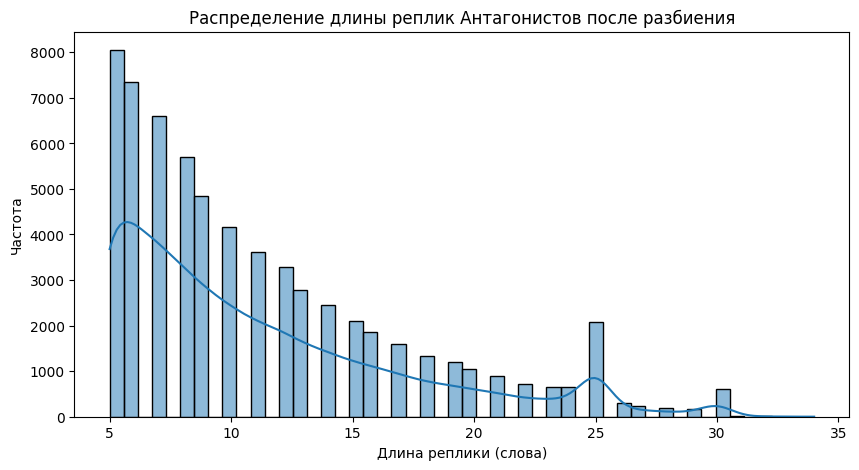

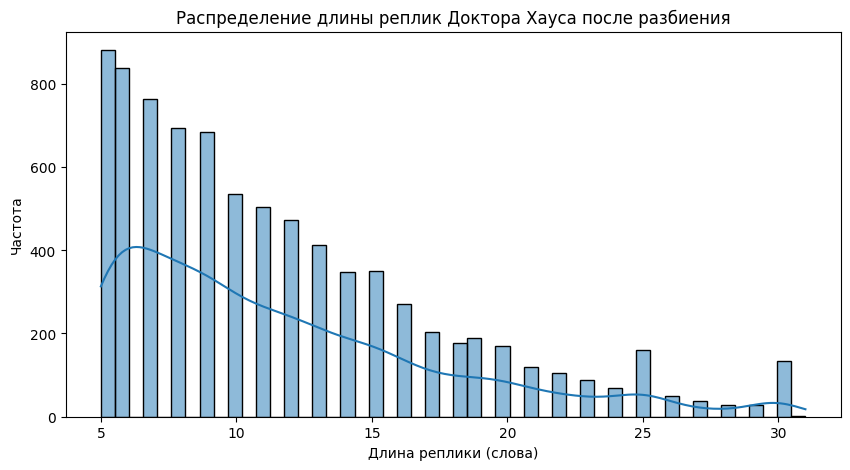

In [82]:
def plot_length_distribution(df, title):
    """
    Строит распределение длины реплик в символах.

    df: DataFrame с колонкой "line".
    title: Заголовок графика.
    """
    lengths = df["line"].apply(lambda x: len(x.split()))  # Количество слов в каждой реплике

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("Длина реплики (слова)")
    plt.ylabel("Частота")
    plt.title(title)
    plt.show()

# Построение графиков
plot_length_distribution(antagonists_df, "Распределение длины реплик Антагонистов после разбиения")
plot_length_distribution(house_df, "Распределение длины реплик Доктора Хауса после разбиения")

In [83]:
# Проверяем количество пустых и NaN значений в анкорах
num_empty_anchors = (house_df["anchor"] == "").sum()
num_nan_anchors = house_df["anchor"].isna().sum()

print(f"Пустых анкоров: {num_empty_anchors}")
print(f"NaN анкоров: {num_nan_anchors}")

# Если есть пустые значения, выводим примеры
if num_empty_anchors > 0 or num_nan_anchors > 0:
    print("\nПримеры пустых анкоров:")
    print(house_df[house_df["anchor"].isna() | (house_df["anchor"] == "")].head())


Пустых анкоров: 1
NaN анкоров: 0

Примеры пустых анкоров:
       name  season previous_line previous_speaker  \
1924  house       2                 mandarin woman   

                                           context_long  is_greeting  \
1924  I can count to ten and ask to go to the bathro...        False   

      is_question  is_negation  is_exclamation  is_sarcasm  ...  \
1924        False        False           False        True  ...   

                                              context_2  \
1924  You speak Mandarin? Okay, Im going to leave yo...   

                                              context_3  \
1924  Her boobs are bigger. You speak Mandarin? Okay...   

                                              context_4  \
1924  Shes been taking the decongestants, but shes n...   

                                              context_5 is_self_question  \
1924  Shes been taking the decongestants, but shes n...            False   

                                           

In [85]:
def fill_last_empty_anchor(row, min_words=5, max_words=20):
    """
    Заполняет последний пустой анкор, используя context_1 -> context_2 -> context_3 и т.д.
    Если ничего не найдено, ставим "UNKNOWN".
    """
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    for col in context_columns:
        context = row.get(col, "")
        if isinstance(context, str) and len(context.strip()) > 0:
            words = context.split()
            if min_words <= len(words) <= max_words:
                return context
            elif len(words) > max_words:
                return " ".join(words[:max_words])  # Берем первые max_words слов

    return "UNKNOWN"  # Если вообще нет контекста

# Заполняем последний пустой анкор
house_df.loc[house_df["anchor"] == "", "anchor"] = house_df[house_df["anchor"] == ""].apply(fill_last_empty_anchor, axis=1)

# Проверяем, остались ли пустые анкоры
empty_anchor_count = (house_df["anchor"] == "").sum()
print(f"Осталось пустых анкоров: {empty_anchor_count}")


Осталось пустых анкоров: 0


In [86]:
# Проверка, содержится ли ответ в анкоре
house_df["answer_in_anchor"] = house_df.apply(lambda row: row["line"] in row["anchor"], axis=1)

# Подсчет количества таких случаев
num_issues = house_df["answer_in_anchor"].sum()
print(f"Количество анкоров, содержащих ответ: {num_issues}")

# Примеры проблемных строк
if num_issues > 0:
    print("\nПримеры анкоров, содержащих ответ:")
    print(house_df[house_df["answer_in_anchor"]][["anchor", "line"]].head(5))

Количество анкоров, содержащих ответ: 18

Примеры анкоров, содержащих ответ:
                                                 anchor  \
54    From what Ive read false paternity is more lik...   
754   Hes not gonna fire anybody. Its not about the ...   
986   What kind of snake? Oh, there are people to fi...   
1557  Ill be right back. So you had a fight, Im sure...   
1560  It was about nothing. You fought over mail del...   

                                                line  
54                        Fifty bucks says Im right.  
754                         Its not about the money.  
986   Oh, there are people to find those things out.  
1557     So you had a fight, Im sure itll blow over.  
1560                   You fought over mail delivery  


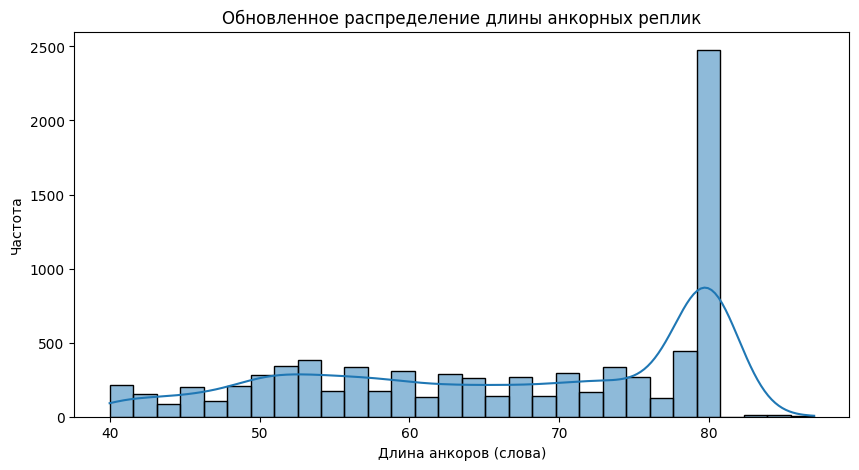

In [22]:
def fix_short_anchors(row, min_length=40):
    """Добавляет дополнительный контекст к слишком коротким анкорам."""
    anchor = row["anchor"]
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    # Если анкор слишком короткий, добавляем контекст
    if count_words(anchor) < min_length:
        for col in context_columns:
            if pd.notna(row[col]) and count_words(row[col]) > 5:  # Берем только осмысленный контекст
                anchor = anchor + " " + row[col]
                if count_words(anchor) >= min_length:
                    break

    return anchor.strip()

# Применяем исправление к слишком коротким анкорам
house_df["anchor"] = house_df.apply(fix_short_anchors, axis=1)

# Визуализация обновленного распределения
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor"].dropna().apply(count_words), bins=30, kde=True)
plt.xlabel("Длина анкоров (слова)")
plt.ylabel("Частота")
plt.title("Обновленное распределение длины анкорных реплик")
plt.show()


In [97]:
from sentence_transformers import SentenceTransformer, util
import torch

# Загружаем модель и отправляем ее на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
model = SentenceTransformer("all-mpnet-base-v2").to(device)


# Векторизация анкоров и негативных примеров
anchor_embeddings = model.encode(house_df["anchor"].tolist(), convert_to_tensor=True, device=device)
antagonist_embeddings = model.encode(antagonists_df["line"].tolist(), convert_to_tensor=True, device=device)

# Вычисление косинусного сходства
similarities = util.pytorch_cos_sim(anchor_embeddings, antagonist_embeddings).cpu().numpy()

In [98]:
import numpy as np

threshold_lower = 0.05  # Ослабляем нижний порог
threshold_upper = 0.2   # Уменьшаем верхний порог
top_k = 50  # Расширяем выборку для негативных примеров

# Преобразование DataFrame в массивы
antagonist_lines = antagonists_df["line"].values
similarities_np = np.array(similarities)

# Создание списка для негативных примеров
new_hard_negatives = np.full(len(house_df), "", dtype=object)

for i in range(similarities_np.shape[0]):
    sorted_idx = np.argsort(similarities_np[i])[::-1]  # Сортировка по убыванию
    candidates = sorted_idx[
        (similarities_np[i][sorted_idx] > threshold_lower) &
        (similarities_np[i][sorted_idx] < threshold_upper)
    ]  # Фильтрация слишком легких и слишком похожих примеров

    if len(candidates) > 5:
        neg_idx = np.random.choice(candidates[:top_k])  # Выбираем случайный из top-k
        new_hard_negatives[i] = antagonist_lines[neg_idx]

# Добавляем в house_df колонку с негативными ответами
house_df["neg_answer"] = new_hard_negatives
print(f"Обновлено {len(new_hard_negatives)} негативных примеров.")

# === Теперь создаем триплеты ===
triplets_df = house_df[["anchor", "line", "neg_answer"]].copy()
triplets_df.columns = ["anchor", "response", "neg_response"]  # Переименовываем для единообразия

print(f"Создано {len(triplets_df)} триплетов.")

# Проверка на NaN
assert triplets_df.isna().sum().sum() == 0, "Есть NaN в триплетах!"


Обновлено 8316 негативных примеров.
Создано 8316 триплетов.


In [106]:
import os
import pickle
from google.colab import files

# Определение директорий для сохранения файлов
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# Пути для сохранения файлов
house_final_path = os.path.join(output_dir, "house_final_cleaned.csv")
antagonists_final_path = os.path.join(output_dir, "antagonists_final_cleaned.csv")
triplets_path = os.path.join(output_dir, "house_triplets.pkl")

# Сохранение обновлённых датасетов
house_df.to_csv(house_final_path, index=False)
antagonists_df.to_csv(antagonists_final_path, index=False)

# Проверяем, что в триплетах нет NaN перед сохранением
assert triplets_df.isna().sum().sum() == 0, "Ошибка: В триплетах есть NaN!"

# Сохранение триплетов в pickle-формате
with open(triplets_path, "wb") as f:
    pickle.dump(triplets_df, f)

print(f"Финальный датасет Доктора Хауса сохранён: {house_final_path}")
print(f"Финальный датасет антагонистов сохранён: {antagonists_final_path}")
print(f"Триплеты сохранены в: {triplets_path}")

# Автоматическая загрузка файлов для скачивания
files.download(house_final_path)
files.download(antagonists_final_path)
files.download(triplets_path)


Финальный датасет Доктора Хауса сохранён: /content/data/house_final_cleaned.csv
Финальный датасет антагонистов сохранён: /content/data/antagonists_final_cleaned.csv
Триплеты сохранены в: /content/data/house_triplets.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Пример загруженных триплетов:
                                              anchor  \
0    And shes not responding to radiation treatment.   
1                        Your cousin goes to an HMO?   
2  Youve got three overqualified doctors working ...   
3                                   Is she a doctor?   
4                                                Dr.   

                                            response neg_response  
0                                    Is she a doctor               
1                                    Is she a doctor               
2                                    Is she a doctor               
3  No, treating illnesses is why we became doctor...               
4  No, treating illnesses is why we became doctor...               


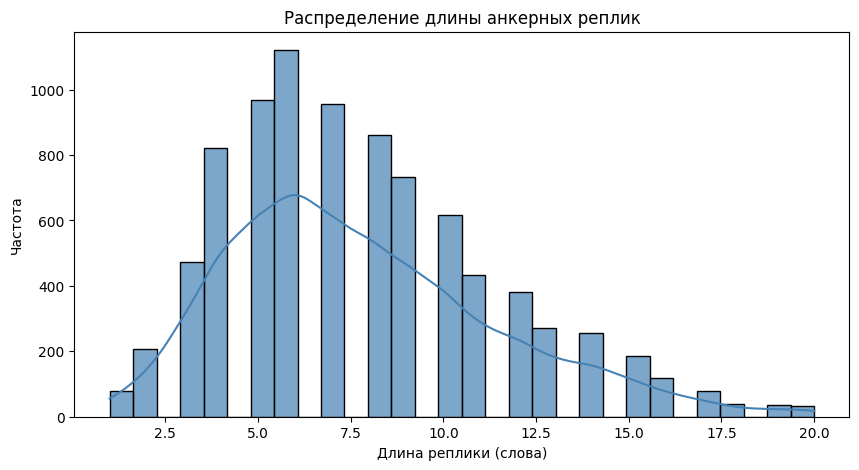

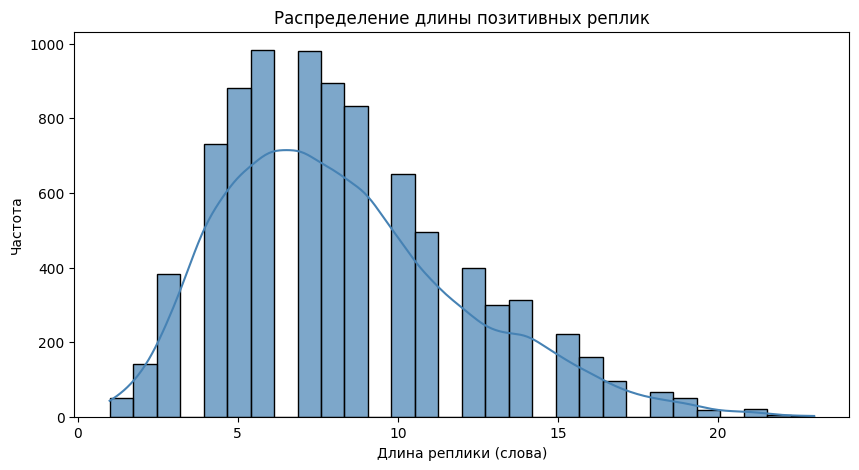

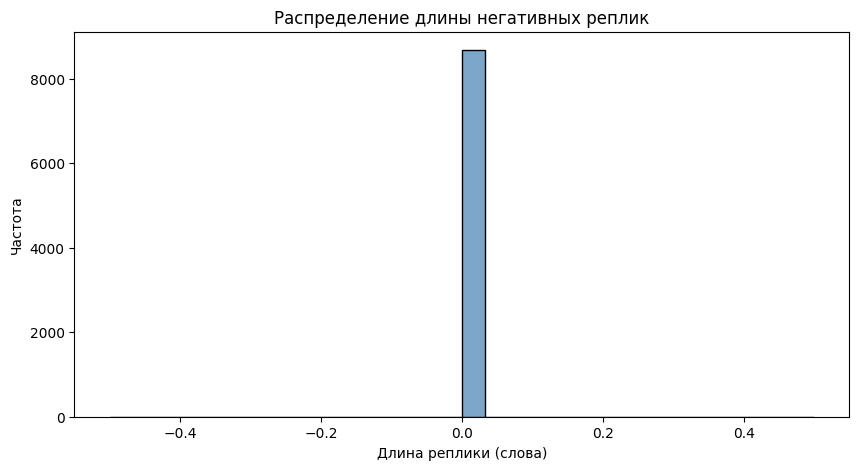

In [107]:
# Пути к сохраненным данным
triplets_path = "/content/data/house_triplets.pkl"

# Загрузка триплетов
with open(triplets_path, "rb") as f:
    triplets_df = pickle.load(f)

# Проверка структуры загруженного датафрейма
print("Пример загруженных триплетов:")
print(triplets_df.head())

# Функция для построения распределения длины реплик
def plot_length_distribution(df, column_name, title):
    lengths = df[column_name].str.split().str.len()

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True, color="steelblue", alpha=0.7)
    plt.xlabel("Длина реплики (слова)")
    plt.ylabel("Частота")
    plt.title(title)
    plt.show()

# Построение графиков
plot_length_distribution(triplets_df, "anchor", "Распределение длины анкерных реплик")
plot_length_distribution(triplets_df, "response", "Распределение длины позитивных реплик")
plot_length_distribution(triplets_df, "neg_response", "Распределение длины негативных реплик")

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Векторизация анкорных реплик, позитивных и негативных ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(triplets_df["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(triplets_df["response"].tolist(), convert_to_numpy=True)
negative_vectors = model.encode(triplets_df["neg_response"].tolist(), convert_to_numpy=True)

# Вычисление косинусного сходства анкорных реплик с позитивными ответами
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(similarity_scores.diagonal())

# Вычисление косинусного сходства анкорных реплик с негативными ответами
neg_similarity_scores = cosine_similarity(anchor_vectors, negative_vectors)
avg_neg_similarity = np.mean(neg_similarity_scores.diagonal())

# Вывод результатов
print(f"Среднее косинусное сходство анкорных реплик и позитивных ответов: {avg_similarity:.4f}")
print(f"Среднее косинусное сходство анкорных реплик и негативных ответов: {avg_neg_similarity:.4f}")

Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и позитивных ответов: 0.2024
Среднее косинусное сходство анкорных реплик и негативных ответов: 0.1996


In [102]:
import pickle
import os

# Определение директорий для сохранения
vector_output_dir = "/content/data/vectors"
os.makedirs(vector_output_dir, exist_ok=True)

# Пути для сохранения векторов
anchor_vectors_path = os.path.join(vector_output_dir, "anchor_vectors.pkl")
response_vectors_path = os.path.join(vector_output_dir, "response_vectors.pkl")
negative_vectors_path = os.path.join(vector_output_dir, "negative_vectors.pkl")

# Сохранение векторов в файлы
with open(anchor_vectors_path, "wb") as f:
    pickle.dump(anchor_vectors, f)

with open(response_vectors_path, "wb") as f:
    pickle.dump(response_vectors, f)

with open(negative_vectors_path, "wb") as f:
    pickle.dump(negative_vectors, f)

print(f"Векторы анкорных реплик сохранены в: {anchor_vectors_path}")
print(f"Векторы позитивных ответов сохранены в: {response_vectors_path}")
print(f"Векторы негативных ответов сохранены в: {negative_vectors_path}")

Векторы анкорных реплик сохранены в: /content/data/vectors/anchor_vectors.pkl
Векторы позитивных ответов сохранены в: /content/data/vectors/response_vectors.pkl
Векторы негативных ответов сохранены в: /content/data/vectors/negative_vectors.pkl
